## Importando recursos

In [362]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer, BertModel
from scipy.special import softmax
from tqdm import tqdm
import gensim
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [363]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Coleta dos dados

In [364]:
df = pd.read_csv('/content/drive/MyDrive/Reviews.csv', encoding='ISO-8859-1', sep=',' )

df = df.head(600)

In [365]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Análise Exploratória

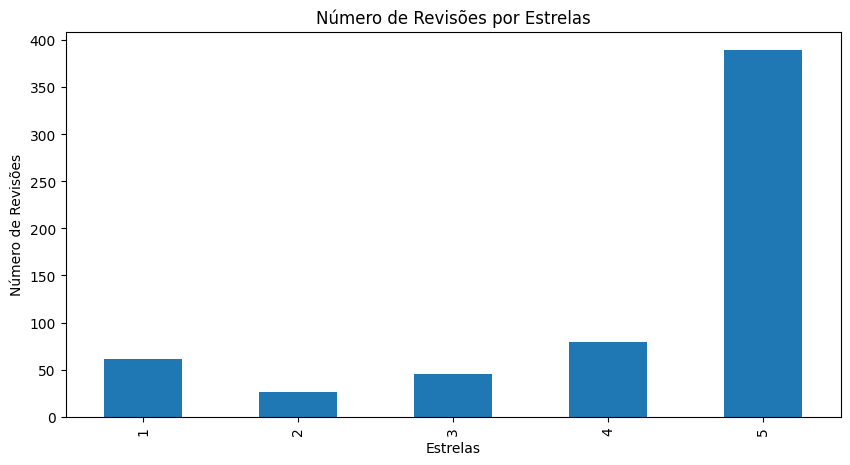

In [366]:
ax = df['Score'].value_counts().sort_index().plot(kind='bar', title='Número de Revisões por Estrelas', figsize=(10, 5))
ax.set_xlabel('Estrelas')
ax.set_ylabel('Número de Revisões')
plt.show()

Análise de Sentimentos

In [367]:
nltk.download('vader_lexicon')
nltk.download('punkt_tab')
nltk.download('words')
nltk.download('maxent_ne_chunker_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [368]:
example_text = df['Text'][24]
print(example_text)

I have lived out of the US for over 7 yrs now, and I so miss my Twizzlers!!  When I go back to visit or someone visits me, I always stock up.  All I can say is YUM!<br />Sell these in Mexico and you will have a faithful buyer, more often than I'm able to buy them right now.


In [369]:
tokens = nltk.word_tokenize(example_text)

tokens[:10]

['I', 'have', 'lived', 'out', 'of', 'the', 'US', 'for', 'over', '7']

In [370]:
tagged = nltk.pos_tag(tokens)

tagged[:10]

[('I', 'PRP'),
 ('have', 'VBP'),
 ('lived', 'VBN'),
 ('out', 'IN'),
 ('of', 'IN'),
 ('the', 'DT'),
 ('US', 'NNP'),
 ('for', 'IN'),
 ('over', 'IN'),
 ('7', 'CD')]

In [371]:
entities = nltk.chunk.ne_chunk(tagged)

entities.pprint()

(S
  I/PRP
  have/VBP
  lived/VBN
  out/IN
  of/IN
  the/DT
  (ORGANIZATION US/NNP)
  for/IN
  over/IN
  7/CD
  yrs/NNS
  now/RB
  ,/,
  and/CC
  I/PRP
  so/RB
  miss/JJ
  my/PRP$
  Twizzlers/NNS
  !/.
  !/.
  When/WRB
  I/PRP
  go/VBP
  back/RB
  to/TO
  visit/NN
  or/CC
  someone/NN
  visits/NNS
  me/PRP
  ,/,
  I/PRP
  always/RB
  stock/NN
  up/RP
  ./.
  All/DT
  I/PRP
  can/MD
  say/VB
  is/VBZ
  (ORGANIZATION YUM/JJ)
  !/.
  </JJ
  br/NN
  //NNP
  >/NNP
  Sell/NNP
  these/DT
  in/IN
  (GPE Mexico/NNP)
  and/CC
  you/PRP
  will/MD
  have/VB
  a/DT
  faithful/JJ
  buyer/NN
  ,/,
  more/RBR
  often/RB
  than/IN
  I/PRP
  'm/VBP
  able/JJ
  to/TO
  buy/VB
  them/PRP
  right/RB
  now/RB
  ./.)


In [372]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Aplicação do modelo SVM com Box of Words (BOW)

## Pré-processamento de dados

In [373]:
# Remove stopwords das avaliações
lemma = WordNetLemmatizer()
stop_words = stopwords.words("english")
review_cleaned = []

for review in df['Text']:
  review = nltk.word_tokenize(review.lower())
  review = [lemma.lemmatize(word) for word in review]

  review = [word for word in review if word not in stop_words]
  review = ' '.join(review)

  review_cleaned.append(review)


In [374]:
vectorizer = CountVectorizer(max_features=10000)
BOW = vectorizer.fit_transform(review_cleaned)

## Separando entre conjuntos de treino e teste

In [375]:
bow_x_train,bow_x_test,bow_y_train,bow_y_test = train_test_split(BOW, np.asarray(df['Score']))

print(bow_x_train.shape)
print(bow_x_test.shape)
print(bow_y_train.shape)
print(bow_y_test.shape)

(450, 3986)
(150, 3986)
(450,)
(150,)


## Classificando o SVM e buscando sua acurácia

In [376]:
svm_model = SVC()
svm_model.fit(bow_x_train, bow_y_train)

bow_y_pred = svm_model.predict(bow_x_test)

print("Acurácia: ", svm_model.score(bow_x_test,bow_y_test))

Acurácia:  0.62


# Aplicação de modelo BERT

In [377]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

## Separando entre conjuntos de treino e teste

In [378]:
bert_x_train, bert_x_test, bert_y_train, bert_y_test = train_test_split(df['Text'], df['Score'], test_size=0.2, random_state=42)

print(bert_x_train.shape)
print(bert_x_test.shape)
print(bert_y_train.shape)
print(bert_y_test.shape)

(480,)
(120,)
(480,)
(120,)


Gerando os embeddings com os modelos do BERT

In [379]:
def get_bert_embeddings(texts):
    embeddings = []
    for text in tqdm(texts):
        inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        outputs = bert_model(**inputs)
        embeddings.append(outputs.last_hidden_state[:, 0, :].detach().numpy())
    return np.vstack(embeddings)

In [380]:
x_train_embedded = get_bert_embeddings(bert_x_train)
x_test_embedded = get_bert_embeddings(bert_x_test)

100%|██████████| 120/120 [00:56<00:00,  2.13it/s]


In [381]:
bert_model = SVC()
bert_model.fit(x_train_embedded, bert_y_train)

bert_y_pred = bert_model.predict(x_test_embedded)

# Aplicação de modelo SVM com Embeddings

In [382]:
# Pré-processamento textual antes de treinar o modelo Word2Vec
from nltk.tokenize import word_tokenize
# tokenizador de sentença do nltk
nltk.download('punkt')

tokenized = [word_tokenize(i) for i in df['Text'].values]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [383]:
from gensim.models import Word2Vec
model = Word2Vec(tokenized, vector_size=50, window=5, min_count=1, workers=4)

In [384]:
model.wv.most_similar('free')

[('has', 0.9987568259239197),
 ('only', 0.9986949563026428),
 ('other', 0.9986229538917542),
 ('or', 0.9986116290092468),
 ('are', 0.9985514283180237),
 ('flavors', 0.998540461063385),
 ('&', 0.9985109567642212),
 ('from', 0.9984948635101318),
 ('out', 0.998481810092926),
 ('a', 0.9984713196754456)]

## Processamento de texto em sequence

In [385]:
def create_sequence(words_list, words_max, seq_len, matrix):
  res = {}
  res['seq_len'] = seq_len
  res['embed_matrix'] = matrix

  temp_vocab = list(set(words_list))
  word_cnts = {}

  for word in temp_vocab:
      count = len([0 for w in words_list if w == word])
      word_cnts[word] = count
      counts = list(word_cnts.values())
      indexes = list(range(len(counts)))

  res['word_cnts'] = word_cnts

  cnt = 0
  while cnt + 1 != len(counts):
      cnt = 0
      for i in range(len(counts) - 1):
          if counts[i] < counts[i + 1]:
              counts[i + 1],counts[i] = counts[i],counts[i + 1]
              indexes[i],indexes[i + 1] = indexes[i + 1],indexes[i]
          else:
              cnt += 1

  vocab = []
  for ind in indexes[:words_max]:
      vocab.append(temp_vocab[ind])

  res['vocab'] = vocab

  return res

In [386]:
def text_to_vector(sequence, text):
  text_tokens = text.split()
  length = len(text_tokens)-1 if len(text_tokens) < sequence['seq_len'] else sequence['seq_len'] -1
  vector = []

  for tk in text_tokens[:length]:
    try:
      vector.append(sequence['embed_matrix'][tk])
    except:
      pass

  last = sequence['seq_len'] - len(vector)
  for i in range(last):
    vector.append(np.zeros(sequence['embed_matrix'].vector_size))

  return np.asarray(vector).flatten()

In [387]:
sequence = create_sequence(
    [token for seq in tokenized for token in seq],
    1200,
    15,
    model.wv)

tst_vector = text_to_vector(sequence, df['Text'][0])
tst_vector.shape

(750,)

## Aplicando PCA para reduzir o tempo do classificador SVM

In [388]:
x_vector = np.asarray([text_to_vector(sequence, " ".join(text)) for text in tokenized])
x_vector.shape

(600, 750)

In [389]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=50)

pca_model.fit(x_vector)

# Valida a % de eficácia dos componentes do PCA
print("Soma da Variância: ",sum(pca_model.explained_variance_ratio_))

Soma da Variância:  0.9990938168165059


In [390]:
x_compressed = pca_model.transform(x_vector)
x_compressed.shape

(600, 50)

## Dividindo os dados de Treino e Teste

In [391]:
svm_x_train,svm_x_test,svm_y_train,svm_y_test = train_test_split(x_compressed, df['Score'], test_size=0.2, random_state=42)

print(svm_x_train.shape)
print(svm_x_test.shape)
print(svm_y_train.shape)
print(svm_y_test.shape)

(480, 50)
(120, 50)
(480,)
(120,)


## Classificando o SVM

In [392]:
svm = SVC()
svm.fit(svm_x_train,svm_y_train)

y_pred = svm.predict(svm_x_test)

print("Acurácia: ", svm.score(svm_x_test,svm_y_test))

Acurácia:  0.6416666666666667


# Avaliando os Três Modelos

In [393]:
from sklearn.metrics import accuracy_score, f1_score

In [394]:
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    print(f"Modelo: {model_name}")
    print(f"Acurácia: {accuracy:.4f}")
    print(f"F1: {f1:.4f}\n")
    return accuracy, f1

In [395]:
## SVM + BOW
evaluate_model(bow_y_test, bow_y_pred, "SVM + BOW")

Modelo: SVM + BOW
Acurácia: 0.6200
F1: 0.4746



(0.62, 0.4745679012345678)

In [396]:
## BERT
evaluate_model(bert_y_test, bert_y_pred, "BERT")

Modelo: BERT
Acurácia: 0.6417
F1: 0.5016



(0.6416666666666667, 0.5016074450084602)

In [397]:
## SVM + Embeddings
evaluate_model(svm_y_test, y_pred, "SVM + Embeddings")

Modelo: SVM + Embeddings
Acurácia: 0.6417
F1: 0.5016



(0.6416666666666667, 0.5016074450084602)